# Intermodel figure

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cf_xarray

In [4]:
import cmocean as cm

In [5]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
# Import the data (names generalised to use for both comparisons)
data_1 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_anom_prescribed_pan01.nc', chunks = 'auto')
data_2 = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_anom_prescribed_ACCESS.nc', chunks = 'auto')

In [7]:
# Land and contour data
depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
land_1 = xr.where(np.isnan(depth_1.rename('land_1')), 1, np.nan)
depth_1_shelf, shelf_contour_1 = shelf_mask_isobath(depth_1, 'mom6_01')

depth_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask_2 = (0 * depth_2).fillna(1)
land_2 = xr.where(np.isnan(depth_2.rename('land_2')), 1, np.nan)
depth_2_shelf, shelf_contour_2 = shelf_mask_isobath(depth_2, 'mom5')

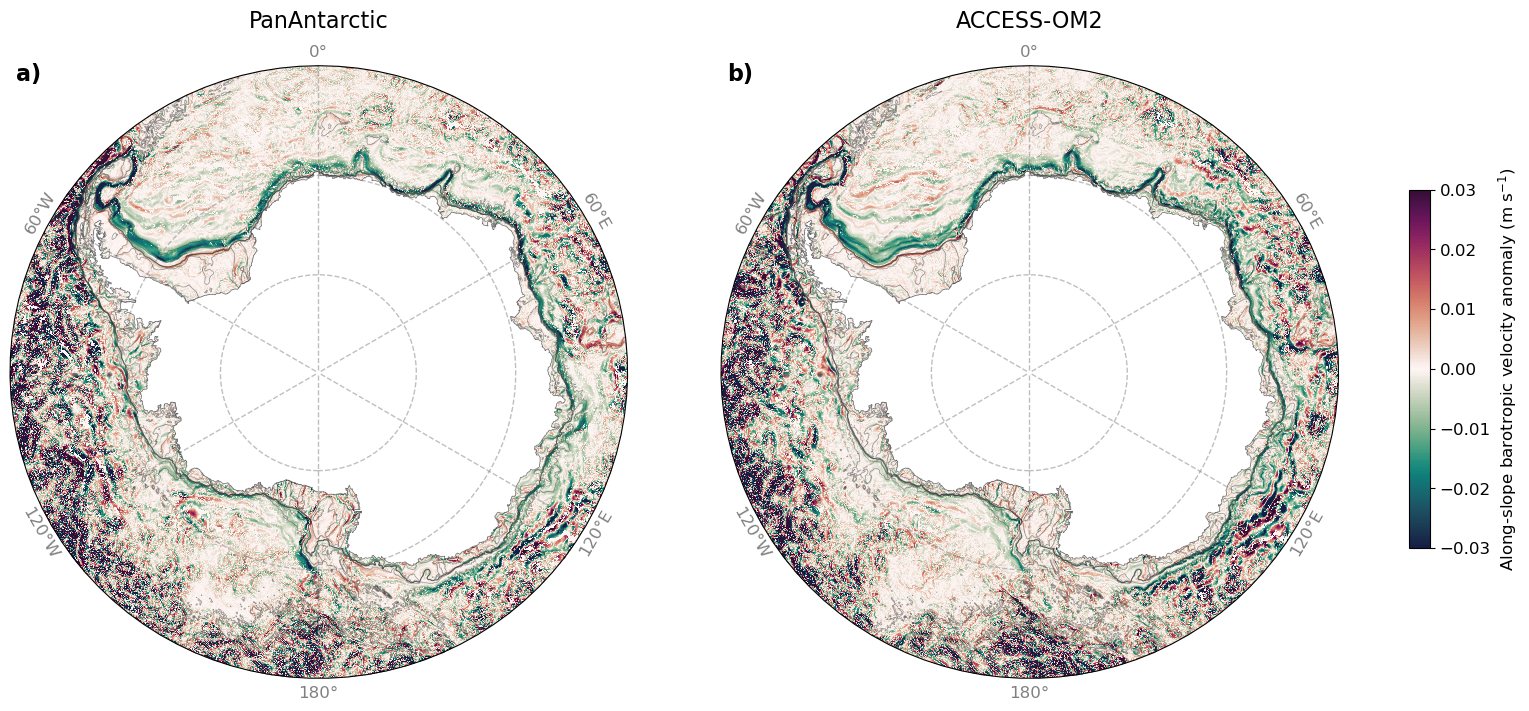

In [81]:
plt.rcParams['font.size'] = 16

# Projection
projection = ccrs.SouthPolarStereo()

# Figure with 2 subplots side by side
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    subplot_kw={"projection": projection},
    figsize=(16, 7),
    constrained_layout=True
)

# Shared circle boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Datasets, land masks, shelf masks, and titles
datasets = [data_1, data_2] 
land_masks = [land_1, land_2]
land_contours = [land_mask_1, land_mask_2]
shelf_masks = [shelf_contour_1, shelf_contour_2]
titles = ["PanAntarctic", "ACCESS-OM2"]
depths = [depth_1, depth_2]
xnames = ["xh", "xt_ocean"]
ynames = ["yh", "yt_ocean"]

# Longitude label settings for rotation
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W']
rot_lon = [0, 0, -60, -60, 60, 60]
lat_lon_label = [-58, -58, -58, -58, -58, -58]

# Loop over subplots
for i, (ax, data, land_m, land_contour, shelf_m, title, depth,xname,yname) in enumerate(zip(
        axes, datasets, land_masks, land_contours, shelf_masks, titles, depths,xnames,ynames)):

    ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)

    # Filled land
    land_m.plot.contourf(ax=ax, colors='white',
                         zorder=2, transform=ccrs.PlateCarree(),
                         add_colorbar=False)

    # Coast line
    ax.contour(land_contour.cf['X'], land_contour.cf['Y'], land_contour,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Shelf contour
    ax.contour(shelf_m.cf['X'], shelf_m.cf['Y'], shelf_m,
               levels=[0, 1], colors='dimgrey', linewidths=0.5,
               transform=ccrs.PlateCarree())

    # Gridlines (keep as in original plot)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, xlocs=range(-180, 171, 60), ylocs=[],
                      color='gray', alpha=0.5, linestyle='--', zorder=10)
    gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                       linewidth=1, xlocs=[], ylocs=(-80, -70, -55),
                       color='gray', alpha=0.5, linestyle='--', zorder=10)

    # Manually rotate longitude labels
    for j, position in enumerate([0, 180, 60, -120, 120, -60]):
        ax.text(position, lat_lon_label[j], label_lon[j], rotation=rot_lon[j],
                ha='center', va='center', color='gray', fontsize=12,
                transform=ccrs.PlateCarree())

    # Plot dataset
    im = data.plot(
        x=xname, y=yname,
        transform=ccrs.PlateCarree(),
        vmin=-0.03, vmax=0.03,
        extend="both",
        cmap=cm.cm.curl,
        add_colorbar=False,
        ax=ax,
    )

    # Depth contours
    depth.plot.contour(ax=ax, levels=[500, 1000, 2000, 3000],
                    colors='0.2', linewidths=[0.5, 0.75, 0.5, 0.5], alpha=0.5,
                    transform=ccrs.PlateCarree())
    
    # Set title
    ax.set_title(title, fontsize=16, pad=25)

    # Add subplot label (a), (b), etc.
    ax.text(0.01,1, f'{chr(97+i)})', transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left', color='black')


# Smaller shared colorbar on the right
cbar = fig.colorbar(
    im, ax=axes, orientation="vertical",
    fraction=0.015,  # smaller width
    aspect=17,       # longer and thinner
    shrink=0.8, pad=0.05
)
cbar.set_label("Along-slope barotropic velocity anomaly (m s$^{-1}$)", fontsize=12)
cbar.ax.tick_params(labelsize=12)  # tick font size

plt.show()

fig.savefig("/g/data/g40/kc5856/thesis_figures/intermodel_alongslopevelocity_maps.png", dpi=300, bbox_inches='tight')

# Quantifying

In [8]:
# Controls for percentage 
data_1_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_cont_prescribed_pan01.nc', chunks = 'auto')
data_2_C = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_cont_prescribed_ACCESS.nc', chunks = 'auto')

data_1_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_melt_prescribed_pan01.nc', chunks = 'auto')
data_2_M = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/intermodel_barotopic_slope_velocity_melt_prescribed_ACCESS.nc', chunks = 'auto')

In [9]:
# Shelf mask

def shelf_mask_2500_isobath(var, model_dict):

    paths = {
            "mom5": '/g/data/g40/kc5856/access-om2-01-2500m-isobath-contour_masked_above.nc',
            "mom6_01": "/g/data/g40/kc5856/panant-01-2500m-isobath-contour_masked_above.nc"
    }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask


In [10]:
depth_1_shelf, shelf_mask_1_2500 = shelf_mask_2500_isobath(depth_1, 'mom6_01')
depth_2_shelf, shelf_mask_2_2500 = shelf_mask_2500_isobath(depth_2, 'mom5')

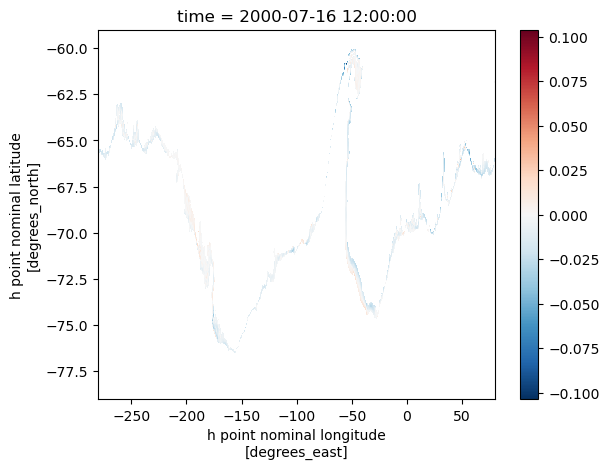

/g/data/xp65/public/apps/med_conda/envs/access-vis-0.1/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/access-vis-0.1/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/access-vis-0.1/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [11]:
data_1.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).plot()

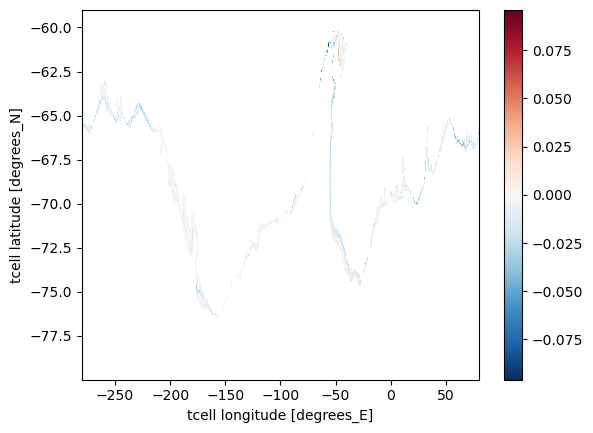

In [12]:
data_2.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).plot()

In [13]:
# Importing areas
# Areas for averaging
area_old_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
area_old_ac = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']
var_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so']
var_ac = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['salt']
area_corr_01 = area_old_01*(var_01.isel(time=0,z_l=0)*0 +1)
area_corr_ac = area_old_ac*(var_ac.isel(time=0,st_ocean=0)*0 +1)

/jobfs/152154285.gadi-pbs/ipykernel_3480907/2065513292.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  var_01 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so']
/jobfs/152154285.gadi-pbs/ipykernel_3480907/2065513292.py:6: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  var_ac = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['salt']


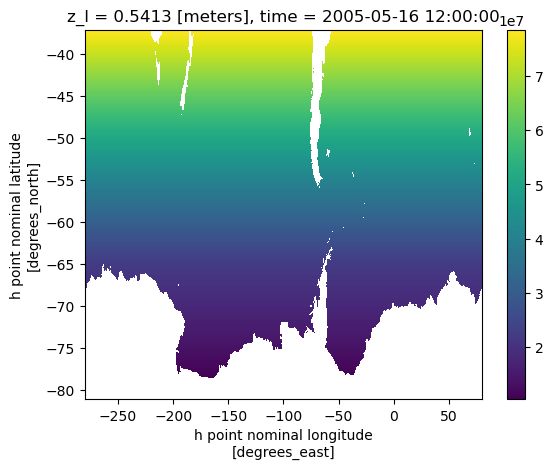

In [14]:
area_corr_01.plot()

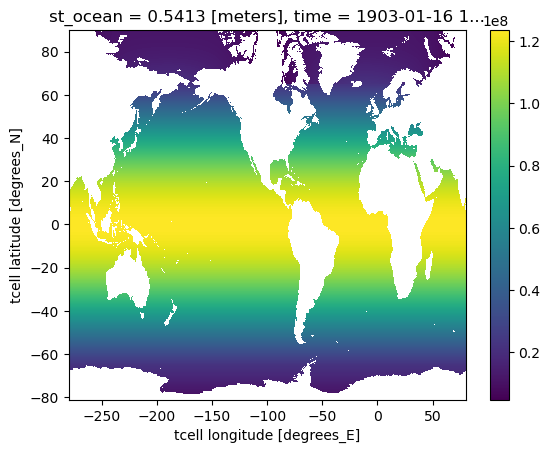

In [15]:
area_corr_ac.plot()

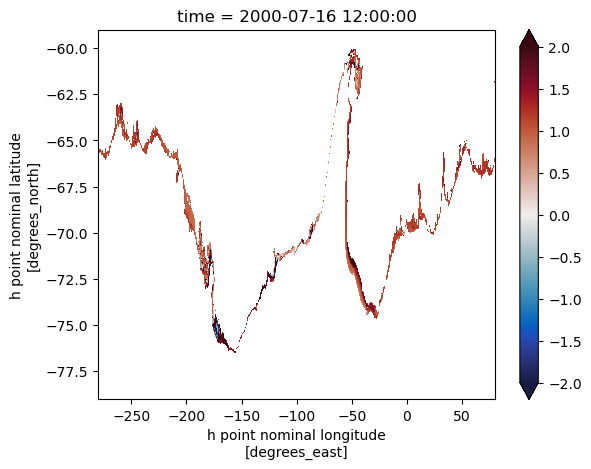

In [30]:
# Panant01
data_1_circ_all = (data_1_M.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)/data_1_C.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1))
data_1_circ_all.plot(vmin=-2,vmax=2,cmap=cm.cm.balance)

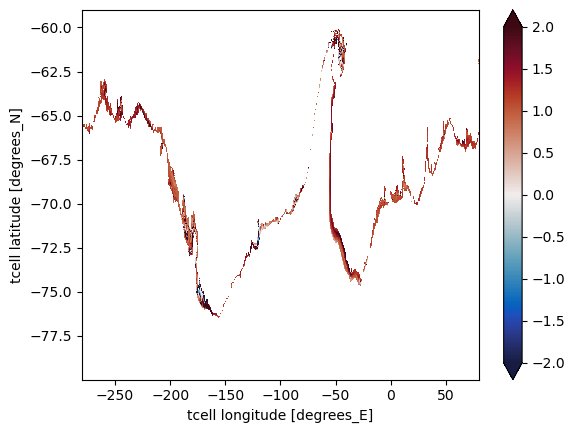

In [29]:
# ACCESS
data_2_circ_all = (data_2_M.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)/data_2_C.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1))
data_2_circ_all.plot(vmin=-2,vmax=2,cmap=cm.cm.balance)

In [32]:
# Spatial average
data_1_C_circ = (area_corr_01 * data_1_C.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_circ = (area_corr_01 * data_1_M.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_circ = (area_corr_ac * data_2_C.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])
data_2_M_circ = (area_corr_ac * data_2_M.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])

In [18]:
(data_1_M_circ/data_1_C_circ).load()

<xarray.DataArray ()> Size: 4B
array(1.1898165, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

/g/data/xp65/public/apps/med_conda/envs/access-vis-0.1/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/access-vis-0.1/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [19]:
(data_2_M_circ/data_2_C_circ).load()

<xarray.DataArray ()> Size: 4B
array(1.1990795, dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
    time      object 8B 1903-01-16 12:00:00

In [20]:
# Spatial average
data_1_C_sect = (area_corr_01 * data_1_C.sel(xh=slice(-60,160)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-60,160)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_sect = (area_corr_01 * data_1_M.sel(xh=slice(-60,160)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-60,160)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_sect = (area_corr_ac * data_2_C.sel(xt_ocean=slice(-60,160)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-60,160)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])
data_2_M_sect = (area_corr_ac * data_2_M.sel(xt_ocean=slice(-60,160)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-60,160)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])

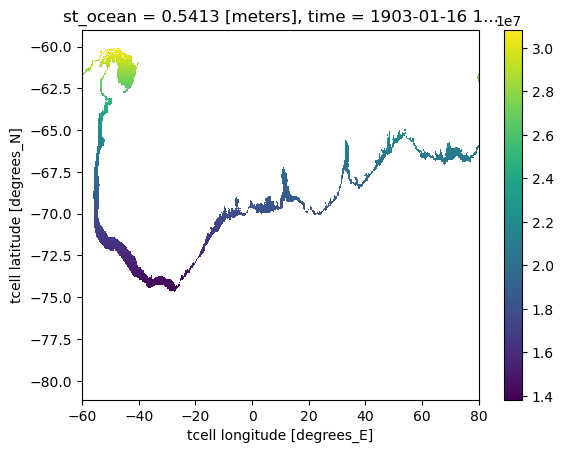

In [21]:
area_corr_ac.sel(xt_ocean=slice(-60,160)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).plot()

In [22]:
(data_1_M_sect/data_1_C_sect).load()

<xarray.DataArray ()> Size: 4B
array(1.2023389, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

/g/data/xp65/public/apps/med_conda/envs/access-vis-0.1/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/access-vis-0.1/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/access-vis-0.1/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/access-vis-0.1/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/access-vis-0.1/lib/python3.11/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [23]:
(data_2_M_sect/data_2_C_sect).load()

<xarray.DataArray ()> Size: 4B
array(1.1826726, dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
    time      object 8B 1903-01-16 12:00:00

In [36]:
WeddellW = -65
WeddellE = 0

# Spatial average
data_1_C_We = (area_corr_01 * data_1_C.sel(xh=slice(-65,0)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-65,0)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_We = (area_corr_01 * data_1_M.sel(xh=slice(-65,0)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-65,0)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_We = (area_corr_ac * data_2_C.sel(xt_ocean=slice(-65,0)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-65,0)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])
data_2_M_We = (area_corr_ac * data_2_M.sel(xt_ocean=slice(-65,0)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-65,0)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])

In [37]:
(data_1_M_We/data_1_C_We).load()

<xarray.DataArray ()> Size: 4B
array(1.2310146, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [38]:
(data_2_M_We/data_2_C_We).load()

<xarray.DataArray ()> Size: 4B
array(1.2183855, dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
    time      object 8B 1903-01-16 12:00:00

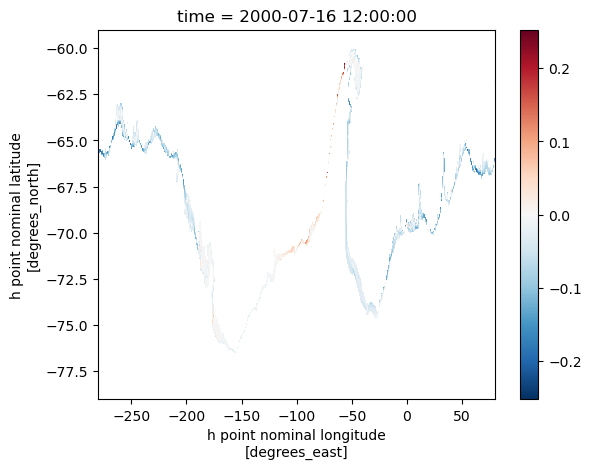

In [40]:
data_1_C.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).plot()

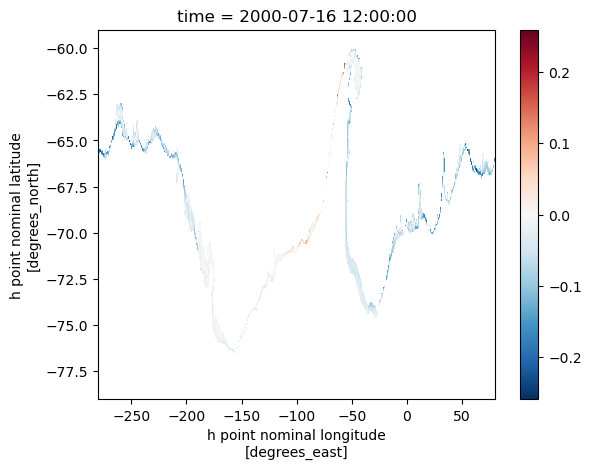

In [39]:
data_1_M.where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).plot()

In [41]:
# West Antarctica
data_1_C_WA = (area_corr_01 * data_1_C.sel(xh=slice(-150,-65)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-150,-65)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_WA = (area_corr_01 * data_1_M.sel(xh=slice(-150,-65)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-150,-65)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_WA = (area_corr_ac * data_2_C.sel(xt_ocean=slice(-150,-65)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-150,-65)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])
data_2_M_WA = (area_corr_ac * data_2_M.sel(xt_ocean=slice(-150,-65)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-150,-65)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])

In [47]:
data_2_M_WA.load()

<xarray.DataArray ()> Size: 4B
array(0.00716029, dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
    time      object 8B 1903-01-16 12:00:00

In [45]:
(1-data_1_M_WA/data_1_C_WA).load()

<xarray.DataArray ()> Size: 4B
array(0.40718442, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [44]:
(1-data_2_M_WA/data_2_C_WA).load()

<xarray.DataArray ()> Size: 4B
array(0.36985576, dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
    time      object 8B 1903-01-16 12:00:00

In [48]:
# Ross Sea
data_1_C_Ro = (area_corr_01 * data_1_C.sel(xh=slice(-200,-150)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-200,-150)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_Ro = (area_corr_01 * data_1_M.sel(xh=slice(-200,-150)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-200,-150)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_Ro = (area_corr_ac * data_2_C.sel(xt_ocean=slice(-200,-150)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-200,-150)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])
data_2_M_Ro = (area_corr_ac * data_2_M.sel(xt_ocean=slice(-200,-150)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-200,-150)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])

In [49]:
(data_1_M_Ro/data_1_C_Ro).load()

<xarray.DataArray ()> Size: 4B
array(1.1201621, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [50]:
(data_2_M_Ro/data_2_C_Ro).load()

<xarray.DataArray ()> Size: 4B
array(1.1192908, dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
    time      object 8B 1903-01-16 12:00:00

In [51]:
# Adelie Coast
data_1_C_Ad = (area_corr_01 * data_1_C.sel(xh=slice(-280,-200)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-280,-200)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_Ad = (area_corr_01 * data_1_M.sel(xh=slice(-280,-200)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-280,-200)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_Ad = (area_corr_ac * data_2_C.sel(xt_ocean=slice(-280,-200)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-280,-200)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])
data_2_M_Ad = (area_corr_ac * data_2_M.sel(xt_ocean=slice(-280,-200)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-280,-200)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])

In [52]:
(data_1_M_Ad/data_1_C_Ad).load()

<xarray.DataArray ()> Size: 4B
array(1.1016108, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [53]:
(data_2_M_Ad/data_2_C_Ad).load()

<xarray.DataArray ()> Size: 4B
array(1.186065, dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
    time      object 8B 1903-01-16 12:00:00

In [54]:
# Adelie Coast
data_1_C_Pr = (area_corr_01 * data_1_C.sel(xh=slice(0,80)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(0,80)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])
data_1_M_Pr = (area_corr_01 * data_1_M.sel(xh=slice(0,80)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(0,80)).where(shelf_contour_1==0).where(shelf_mask_1_2500 ==1).sum(['xh', 'yh'])

data_2_C_Pr = (area_corr_ac * data_2_C.sel(xt_ocean=slice(0,80)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(0,80)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])
data_2_M_Pr = (area_corr_ac * data_2_M.sel(xt_ocean=slice(0,80)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(0,80)).where(shelf_contour_2==0).where(shelf_mask_2_2500 ==1).sum(['xt_ocean', 'yt_ocean'])

In [55]:
(data_1_M_Pr/data_1_C_Pr).load()

<xarray.DataArray ()> Size: 4B
array(1.1911182, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [56]:
(data_2_M_Pr/data_2_C_Pr).load()

<xarray.DataArray ()> Size: 4B
array(1.1673965, dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
    time      object 8B 1903-01-16 12:00:00

In [59]:
# West Antarctica Coastal Current (south of 1000m isobath)
data_1_C_WA_CC = (area_corr_01 * data_1_C.sel(xh=slice(-150,-65)).where(shelf_contour_1==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-150,-65)).where(shelf_contour_1==1).sum(['xh', 'yh'])
data_1_M_WA_CC = (area_corr_01 * data_1_M.sel(xh=slice(-150,-65)).where(shelf_contour_1==1)).sum(['xh', 'yh']) / area_corr_01.sel(xh=slice(-150,-65)).where(shelf_contour_1==1).sum(['xh', 'yh'])

data_2_C_WA_CC = (area_corr_ac * data_2_C.sel(xt_ocean=slice(-150,-65)).where(shelf_contour_2==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-150,-65)).where(shelf_contour_2==1).sum(['xt_ocean', 'yt_ocean'])
data_2_M_WA_CC = (area_corr_ac * data_2_M.sel(xt_ocean=slice(-150,-65)).where(shelf_contour_2==1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_ac.sel(xt_ocean=slice(-150,-65)).where(shelf_contour_2==1).sum(['xt_ocean', 'yt_ocean'])

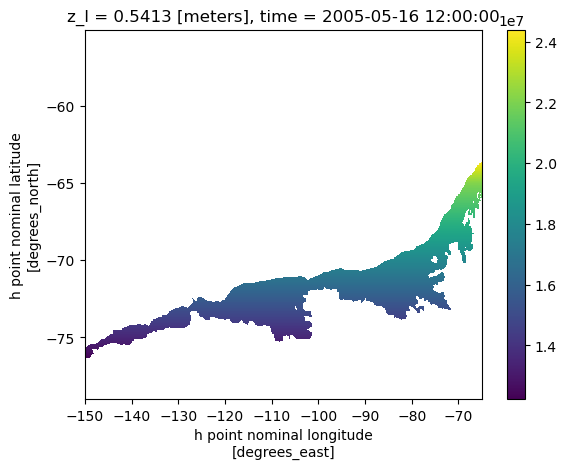

In [58]:
area_corr_01.sel(xh=slice(-150,-65)).where(shelf_contour_1==1).plot()

In [60]:
(data_1_M_WA_CC/data_1_C_WA_CC).load()

<xarray.DataArray ()> Size: 4B
array(1.1671299, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [69]:
data_1_M_WA_CC

<xarray.DataArray ()> Size: 4B
array(-0.00459543, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413
    time     object 8B 2005-05-16 12:00:00

In [70]:
data_2_C_WA_CC

<xarray.DataArray ()> Size: 4B
array(-0.00630841, dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
    time      object 8B 1903-01-16 12:00:00

In [61]:
(data_2_M_WA_CC/data_2_C_WA_CC).load()

<xarray.DataArray ()> Size: 4B
array(1.0709479, dtype=float32)
Coordinates:
    st_ocean  float64 8B 0.5413
    time      object 8B 1903-01-16 12:00:00

# Making ACCESS-OM2 2500m isobath

In [60]:
contour_depth = 2500 # metres
lat_slice = slice(None,-39)

Text(0.5, 1.0, 'Ocean depth (m)')

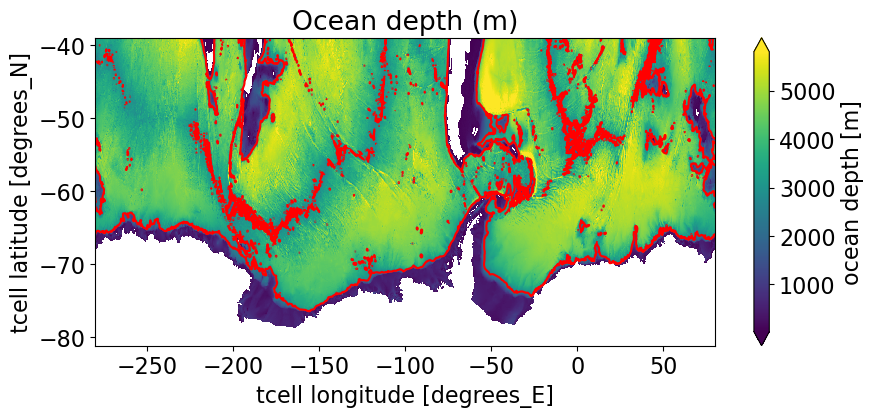

In [62]:
fig = plt.figure(figsize = (10, 4))

depth_2.sel(yt_ocean=lat_slice).plot(extend='both', cbar_kwargs={'label': "ocean depth [m]"})
depth_2.sel(yt_ocean=lat_slice).plot.contour(levels = [contour_depth], colors = 'r', linestyles = '-')
plt.title('Ocean depth (m)')

In [63]:
depth_2_edit = depth_2.sel(yt_ocean=lat_slice).fillna(0).load()

In [64]:
grid_sel = 't'
x_var = depth_2_edit['xt_ocean']
y_var = depth_2_edit['yt_ocean']

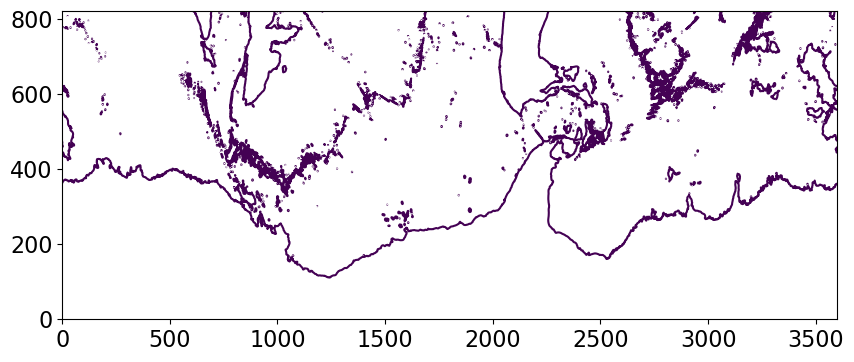

In [65]:
fig = plt.figure(figsize = (10, 4))
sc = plt.contour(depth_2_edit, levels=[contour_depth])

path_vertices = (sc.get_paths()[0]).vertices
x_vertices = path_vertices[:, 0]
y_vertices = path_vertices[:, 1]

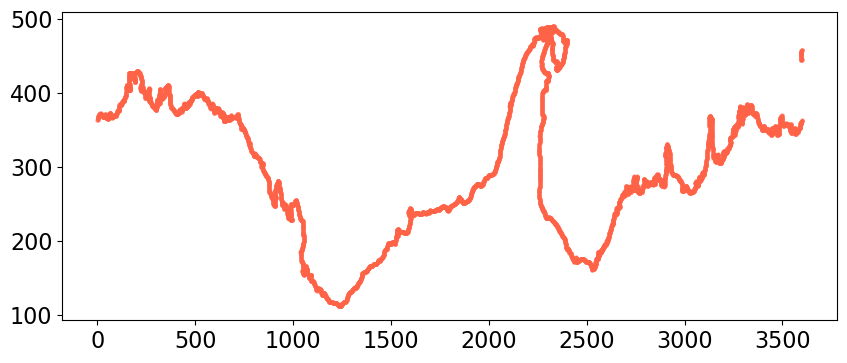

In [66]:
last_contour_index = np.where(np.abs(np.diff(x_vertices).astype(int)) > 1)[0][0]

x_contour = x_vertices[:last_contour_index + 1]
y_contour = y_vertices[:last_contour_index + 1]

# Check desired contour looks right:
fig = plt.figure(figsize = (10, 4))
plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [67]:
x_contour = np.round(x_contour).astype(int)
y_contour = np.round(y_contour).astype(int)

# check that the difference between coords of contour never increase by more than 1:
if np.max(np.abs(np.diff(x_contour))) != 1:
    print('help! x_contour increases by more than 1 between coords.')

if np.max(np.abs(np.diff(y_contour))) != 1:
    print('help! y_contour increases by more than 1 between coords.')

help! y_contour increases by more than 1 between coords.


In [68]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [69]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    x_contour = np.delete(x_contour, index)
    y_contour = np.delete(y_contour, index)

In [70]:
depth_2_edit_contour = np.zeros(len(x_contour))

for ii in range(len(depth_2_edit_contour)):
    depth_2_edit_contour[ii] = depth_2_edit[y_contour[ii], x_contour[ii]]

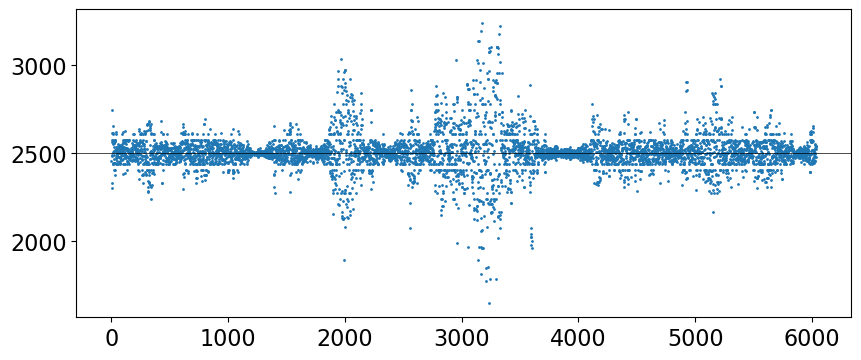

In [72]:
fig = plt.figure(figsize=(10, 4))

plt.plot(depth_2_edit_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [73]:
# Number of grid points on the contour
num_points = len(x_contour)
num_points

6035

In [74]:
# start numbering from 1 not 0:
contour_mask_numbered = np.arange(1, len(x_contour)+1)

In [75]:
contour_mask = xr.zeros_like(depth_2_edit)

for ii in range(num_points):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]

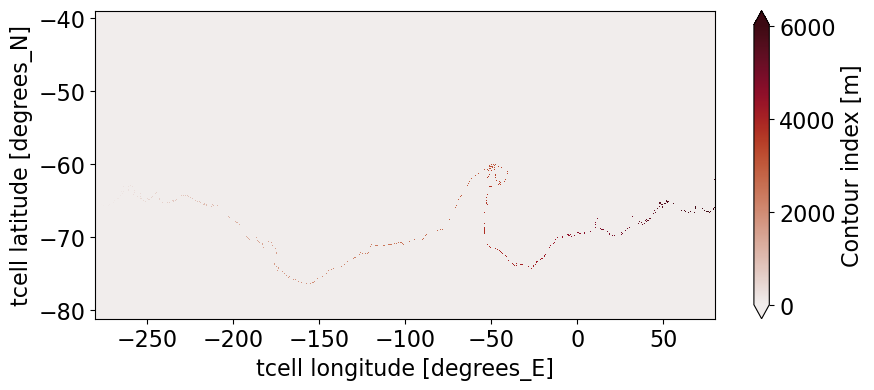

In [82]:
contour_mask.attrs['long_name'] = 'Contour index'
plt.figure(1, figsize=(10, 4))
contour_mask.plot(extend='both', cmap = cm.cm.amp);

In [83]:
contour_mask

<xarray.DataArray 'ht' (yt_ocean: 821, xt_ocean: 3600)> Size: 12MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 7kB -81.11 -81.07 -81.02 ... -39.1 -39.03
    geolon_t  (yt_ocean, xt_ocean) float32 12MB nan nan nan ... 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 12MB nan nan nan ... -39.03 -39.03
Attributes:
    long_name:      Contour index
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid

In [84]:
%%time

mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

CPU times: user 8.87 s, sys: 3 ms, total: 8.88 s
Wall time: 8.87 s


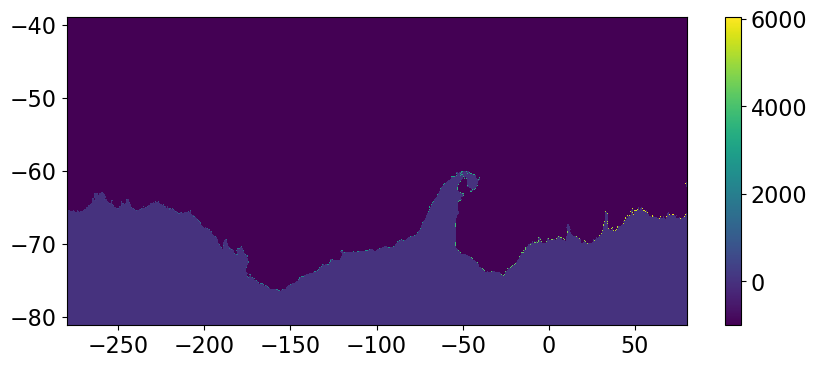

In [85]:
plt.figure(1, figsize=(10, 4))

plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, contour_masked_above)
plt.colorbar()

In [86]:
contour_masked_above_da = xr.DataArray(
    contour_masked_above,
    dims=("yt_ocean", "xt_ocean"),
    coords={"yt_ocean": contour_mask.yt_ocean, "xt_ocean": contour_mask.xt_ocean},
    name="contour_masked_above"
)

In [87]:
contour_masked_above_da

<xarray.DataArray 'contour_masked_above' (yt_ocean: 821, xt_ocean: 3600)> Size: 12MB
array([[    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
       [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
       [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],
      dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 7kB -81.11 -81.07 -81.02 ... -39.1 -39.03
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95

In [88]:
contour_masked_above_da.to_netcdf('/g/data/g40/kc5856/access-om2-01-2500m-isobath-contour_masked_above.nc')